# Activation addition in model bias

This notebook shows how instead of adding a steering vector to the internal activations we can add it to the model bias.

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import os
import numpy as np
from tqdm import tqdm
import gc

In [2]:
# modify to your current working directory (the directory where this notebook is )
cwd = "playing_with_transformers"

# enter your authentication token from huggingface and press enter to access the models
auth_token = input()

In [12]:
# import my modules
import sys
import importlib
# join the path to the modules to the current working directory

sys.path.append(os.path.join(cwd, "modules"))
import wrapping
import utils

importlib.reload(wrapping)
importlib.reload(utils)

from wrapping import WrappedModel
from utils import *


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

model_name = "llama-7b"
model_path = f"huggyllama/{model_name}"

# load model
model = AutoModelForCausalLM.from_pretrained(model_path, token=auth_token).to(device)
model.eval()

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path, token=auth_token)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left' 

num_hidden_layers = model.config.num_hidden_layers
hidden_size = model.config.hidden_size

device: cuda


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/data/ann_kathrin_dombrowski/miniconda3/envs/jup/lib/python3.11/site-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


## Activation editing on the decoder_block

In [5]:
prompt1 = "Love"
prompt2 = "Hate"
coeff = 10
max_new_tokens = 20
layer_id = 5
block_name = "decoder_block"
sentence = "I think dogs are "
# WRAP MODEL
# create wrapped model
wrapped_model = WrappedModel(model, tokenizer)
# make sure nothing is wrapped from previous runs
wrapped_model.unwrap()
# wrap block
wrapped_model.wrap_block(layer_id, block_name=block_name)

In [9]:
# get direction
directions = get_difference(wrapped_model, prompt1, prompt2, [layer_id], [block_name])
steering_vec = directions[block_name][layer_id].to(wrapped_model.device)
steering_vec /= steering_vec.norm()

In [13]:
generations = activation_editing(wrapped_model, [sentence], directions, 
                                   coeff=coeff, printout=True, calc_neutral=True)

No activation addition



I think dogs are 100% better than cats.
I think dogs are 100% better than cats. I think dogs are 1

------------------------------
Positive activation addition

I think dogs are 100% pure and unconditional love.
I think dogs are 100% pure and unconditional love. I think

------------------------------
Negative activation addition

I think dogs are 100% evil.
I think they are the most evil thing on the planet.
I think they are the spawn of Satan.



## Lets push the activation editing into the bias

For activation editing we are adding a vector to the output of the decoder layer. We can also push the vector addition into the bias of the next model layer instead:

$$
W^T(x+v) +b = W^Tx + W^Tv + b = W^Tx + \tilde{b}
$$

The Llama model structure looks as follows:

```
LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
      (1): LlamaDecoderLayer(...
      
      ...
 ```
 
The output of the decoder layer is however not the same as the output of the `post_attention_layernorm` layer. 

A layer in the Llama model (`/lib/python3.9/site-packages/transformers/models/llama/modeling_llama.py`) looks like this:

```python
class LlamaDecoderLayer(nn.Module):
    
    ...
    
    def forward(self, ...
    ) -> Tuple[torch.FloatTensor, Optional[Tuple[torch.FloatTensor, torch.FloatTensor]]]:

        residual = hidden_states

        hidden_states = self.input_layernorm(hidden_states)

        # Self Attention
        hidden_states, self_attn_weights, present_key_value = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_value=past_key_value,
            output_attentions=output_attentions,
            use_cache=use_cache,
        )
        hidden_states = residual + hidden_states

        # Fully Connected
        residual = hidden_states
        hidden_states = self.post_attention_layernorm(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = residual + hidden_states

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (self_attn_weights,)

        if use_cache:
            outputs += (present_key_value,)

        return outputs
```

So if we modify the output of a decoder block then the next decoder block gets this as input `hidden_states`.

1. The output from the previous layer is passed to `self.input_layernorm`.
2. The output from the previous layer is also saved as `residual`, added to the output of `self.self_attn` and passed to `post_attention_layernorm`
3. The sum of the output from the previous layer and the output of `self.self_attn` is then added to the output of the `mlp` layer which is then the actual output of the decoder layer

This then poses a problem, since we add to the residual stream and the residual stream is not only passed into the next layer but also added to the next layer output. This way part of our modification can never bw replaced by modifying the bias.

This might become clear by considering this picture:
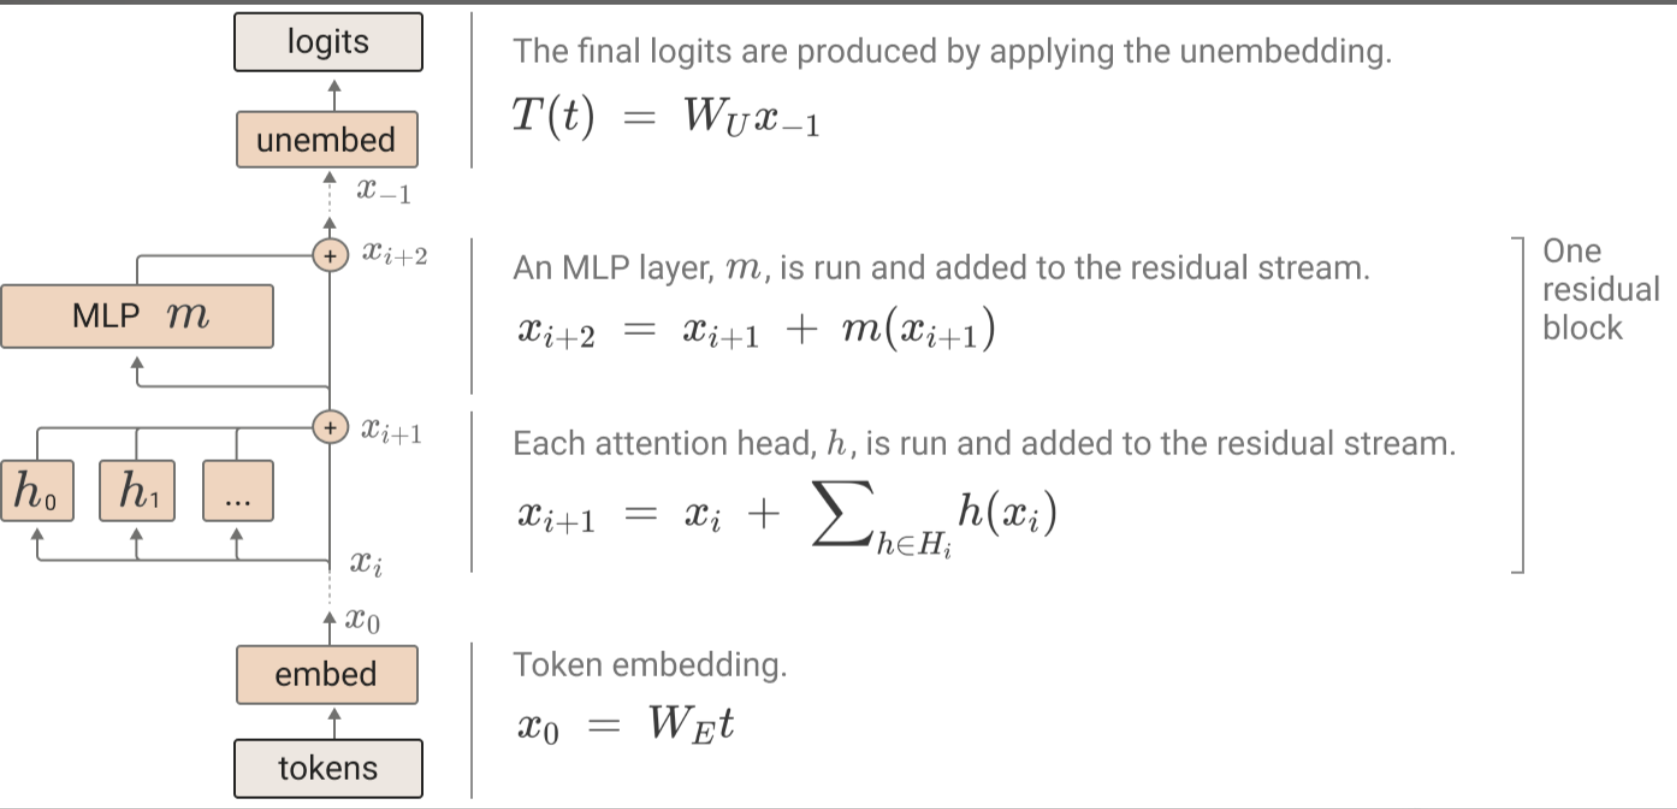


If you look at the image: we do our activation addition on $x_i$. $x_i$ is then passed to some layer, but it is also added directly to $x_{i+1}$. $x_{i=1}$ again passes through the mlp layer but is also directly added to $x_{i+2}$.

It then seems like only when adding our steering vector to the outputs of `input_layernorm` or `post_attention_layernorm` it would be possible to instead modify the bias of the next layer.

My experiments at some point showed that adding to the output of `post_attention_layernorm` does not work so well, so lets try to add to `input_layernorm` and check if this is equivalent to modifying the bias in the next layer.

There are some challenges:

1. In order to identify the wrapping tokens I use `kwargs["position_ids"]` which is accessible in the decoder layer and also in `self_attn` but not in `input_layernorm`. 
2. The layer that comes after `input_layernorm` is `self_attn` and the `hidden_states` which we modified would be passed into several linear layers in the attention block. We will have to modify all of these.
3. The linear layer in the attention block do not actually have any biases

Here is the structure of the attention block:

```
       (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
```

In the forward pass the hidden states are not passed through `o_proj`, so we only have to modify `q_proj`, `k_proj` and `v_proj`.

The `LlamaAttention` class looks as follows:

```python

class LlamaAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(self, config: LlamaConfig):
        super().__init__()
        self.config = config
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.hidden_size // self.num_heads
        self.max_position_embeddings = config.max_position_embeddings

        if (self.head_dim * self.num_heads) != self.hidden_size:
            raise ValueError(
                f"hidden_size must be divisible by num_heads (got `hidden_size`: {self.hidden_size}"
                f" and `num_heads`: {self.num_heads})."
            )
        self.q_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim, bias=False)
        self.k_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim, bias=False)
        self.v_proj = nn.Linear(self.hidden_size, self.num_heads * self.head_dim, bias=False)
        self.o_proj = nn.Linear(self.num_heads * self.head_dim, self.hidden_size, bias=False)
        self.rotary_emb = LlamaRotaryEmbedding(self.head_dim, max_position_embeddings=self.max_position_embeddings)


    def forward(self, ...
               ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        bsz, q_len, _ = hidden_states.size()

        query_states = self.q_proj(hidden_states).view(bsz, q_len, self.num_heads, self.head_dim).transpose(1, 2)
        key_states = self.k_proj(hidden_states).view(bsz, q_len, self.num_heads, self.head_dim).transpose(1, 2)
        value_states = self.v_proj(hidden_states).view(bsz, q_len, self.num_heads, self.head_dim).transpose(1, 2)

```

In [14]:
prompt1 = "Love"
prompt2 = "Hate"
coeff = 10
max_new_tokens = 20
layer_id = 5
block_name = "input_layernorm"
sentence = "I think dogs are "
# WRAP MODEL
# create wrapped model
wrapped_model = WrappedModel(model, tokenizer)
# make sure nothing is wrapped from previous runs
wrapped_model.unwrap()

# check the generation with no edits
print(f"Generations without activation editing")
print(wrapped_model.generate(sentence, max_new_tokens=max_new_tokens)[0])

Generations without activation editing


I think dogs are 100% better than cats.
I think dogs are 100% better


In [15]:
# wrap model
wrapped_model.wrap_block(layer_id, block_name=block_name)
# get direction
directions = get_difference(wrapped_model, prompt1, prompt2, [layer_id], [block_name])
steering_vec = directions[block_name][layer_id].to(wrapped_model.device)
steering_vec /= steering_vec.norm()

In [16]:
wrapped_model.set_to_add(layer_id, coeff*steering_vec, block_name=block_name)
print(f"Generations with activation editing at block {block_name} and coeff = {coeff}\n")
print(wrapped_model.generate(sentence, max_new_tokens=max_new_tokens)[0])

Generations with activation editing at block input_layernorm and coeff = 10



I think dogs are 100% human.
I think cats are 100% cat.



In [17]:
wrapped_model.set_to_add(layer_id, -coeff*steering_vec, block_name=block_name)
print(f"Generations with activation editing at block {block_name} and coeff = {-coeff}\n")
print(wrapped_model.generate(sentence, max_new_tokens=max_new_tokens)[0])

Generations with activation editing at block input_layernorm and coeff = -10



I think dogs are 100% responsible for the death of the human race.
I think that the human race


In [18]:
# unwrap again to remove the activation addition vector
wrapped_model.unwrap()
# check the generation with no edits
print(f"Generations without activation editing")
print(wrapped_model.generate(sentence, max_new_tokens=max_new_tokens)[0])

Generations without activation editing


I think dogs are 100% better than cats.
I think dogs are 100% better


In [19]:
def change_biases_self_attn(wrapped_model, layer_id, steering_vec, coeff):
    for i in range(wrapped_model.model.config.num_hidden_layers):
        # reset all biases to None
        wrapped_model.model.model.layers[i].self_attn.q_proj.bias = None
        wrapped_model.model.model.layers[i].self_attn.k_proj.bias = None
        wrapped_model.model.model.layers[i].self_attn.v_proj.bias = None
        
    # calc vectors W^Tv to add to bias
    b_q = wrapped_model.model.model.layers[layer_id].self_attn.q_proj(steering_vec*coeff)
    b_k = wrapped_model.model.model.layers[layer_id].self_attn.k_proj(steering_vec*coeff)
    b_v = wrapped_model.model.model.layers[layer_id].self_attn.v_proj(steering_vec*coeff)

    # set biases
    wrapped_model.model.model.layers[layer_id].self_attn.q_proj.bias = torch.nn.parameter.Parameter(b_q)
    wrapped_model.model.model.layers[layer_id].self_attn.k_proj.bias = torch.nn.parameter.Parameter(b_k)
    wrapped_model.model.model.layers[layer_id].self_attn.v_proj.bias = torch.nn.parameter.Parameter(b_v)

In [20]:
# check the generation with positive edits
change_biases_self_attn(wrapped_model, layer_id, steering_vec, coeff)
print(wrapped_model.generate(sentence, max_new_tokens=max_new_tokens)[0])

I think dogs are 100% human.
I think cats are 100% cat.



In [21]:
# check the generation with negative edits
change_biases_self_attn(wrapped_model, layer_id, steering_vec, -coeff)
print(wrapped_model.generate(sentence, max_new_tokens=max_new_tokens)[0])

I think dogs are 100% responsible for the death of the human race.
I think that the human race
